# Distribution inspection

Visualize node index visitation and hash output distributions across rounds.

In [1]:
import sys
from pathlib import Path

cwd = Path.cwd().resolve()
repo_root = cwd.parent if cwd.name == 'scripts' else cwd
sys.path.insert(0, str(repo_root))


In [2]:
import math
import random
from collections import Counter

import matplotlib.pyplot as plt

from problem import Tree, Input, build_mem_image, reference_kernel2


In [3]:
def collect_distributions(
    forest_height=10,
    rounds=16,
    batch_size=256,
    trials=20,
    seed=123,
):
    idx_counts = Counter()
    hash_counts = Counter()
    stage_counts = [Counter() for _ in range(6)]

    rng = random.Random(seed)
    for _ in range(trials):
        random.seed(rng.randrange(1 << 30))
        forest = Tree.generate(forest_height)
        inp = Input.generate(forest, batch_size, rounds)
        mem = build_mem_image(forest, inp)

        trace = {}
        for _ in reference_kernel2(mem, trace):
            pass

        for key, val in trace.items():
            if len(key) == 3:
                _, _, kind = key
                if kind == "idx":
                    idx_counts[val] += 1
                elif kind == "hashed_val":
                    hash_counts[val] += 1
            elif len(key) == 4:
                _, _, kind, stage = key
                if kind == "hash_stage":
                    stage_counts[stage][val] += 1

    return idx_counts, hash_counts, stage_counts


In [4]:
forest_height = 10
rounds = 16
batch_size = 256
trials = 20

idx_counts, hash_counts, stage_counts = collect_distributions(
    forest_height=forest_height,
    rounds=rounds,
    batch_size=batch_size,
    trials=trials,
    seed=123,
)

print(f"Collected {sum(idx_counts.values())} node visits")
print(f"Collected {sum(hash_counts.values())} hash outputs")


Collected 81920 node visits
Collected 81920 hash outputs


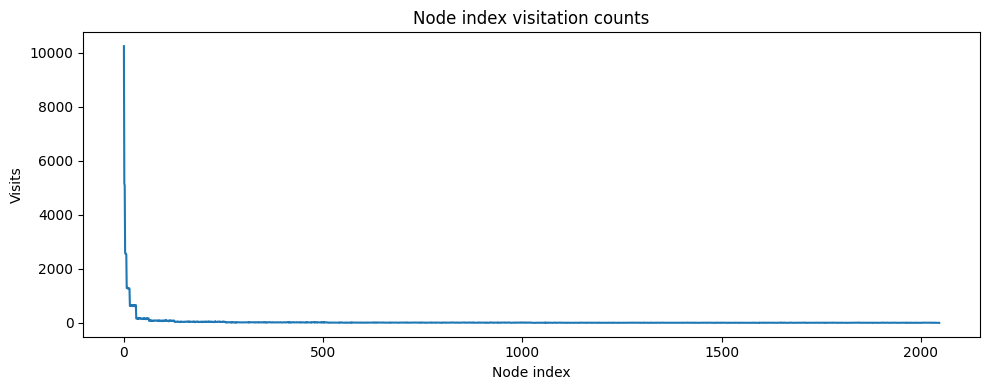

In [5]:
n_nodes = 2 ** (forest_height + 1) - 1
idx_hist = [idx_counts.get(i, 0) for i in range(n_nodes)]

plt.figure(figsize=(10, 4))
plt.plot(idx_hist)
plt.title("Node index visitation counts")
plt.xlabel("Node index")
plt.ylabel("Visits")
plt.tight_layout()
plt.show()


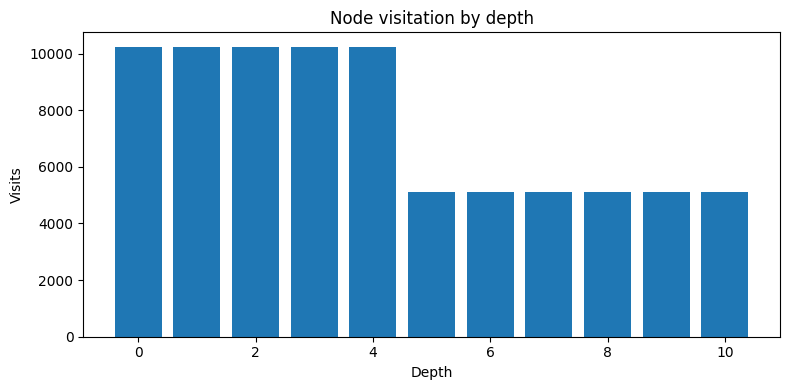

In [6]:
depth_counts = Counter()
for idx, count in idx_counts.items():
    depth = int(math.floor(math.log2(idx + 1)))
    depth_counts[depth] += count

depth_hist = [depth_counts.get(d, 0) for d in range(forest_height + 1)]
plt.figure(figsize=(8, 4))
plt.bar(range(forest_height + 1), depth_hist)
plt.title("Node visitation by depth")
plt.xlabel("Depth")
plt.ylabel("Visits")
plt.tight_layout()
plt.show()


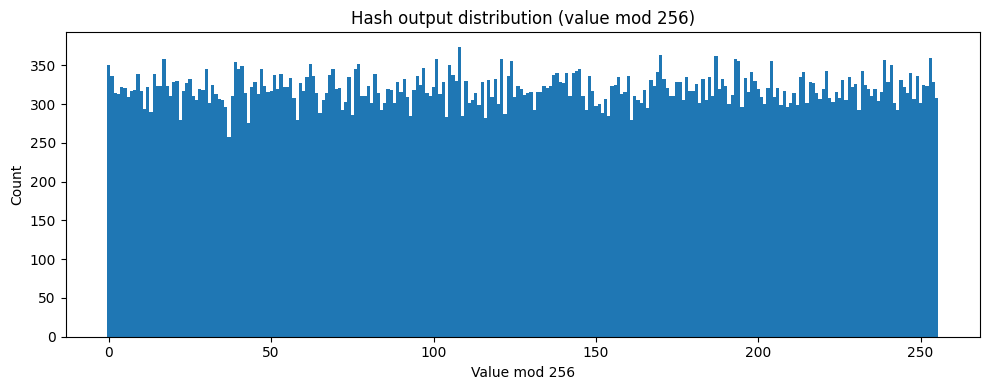

Hash parity: even=40880, odd=41040


In [7]:
def hash_bucket_counts(counter, mod=256):
    buckets = [0] * mod
    for val, count in counter.items():
        buckets[val % mod] += count
    return buckets

hash_buckets = hash_bucket_counts(hash_counts, mod=256)
plt.figure(figsize=(10, 4))
plt.bar(range(256), hash_buckets, width=1.0)
plt.title("Hash output distribution (value mod 256)")
plt.xlabel("Value mod 256")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

even = sum(count for val, count in hash_counts.items() if val % 2 == 0)
odd = sum(hash_counts.values()) - even
print(f"Hash parity: even={even}, odd={odd}")


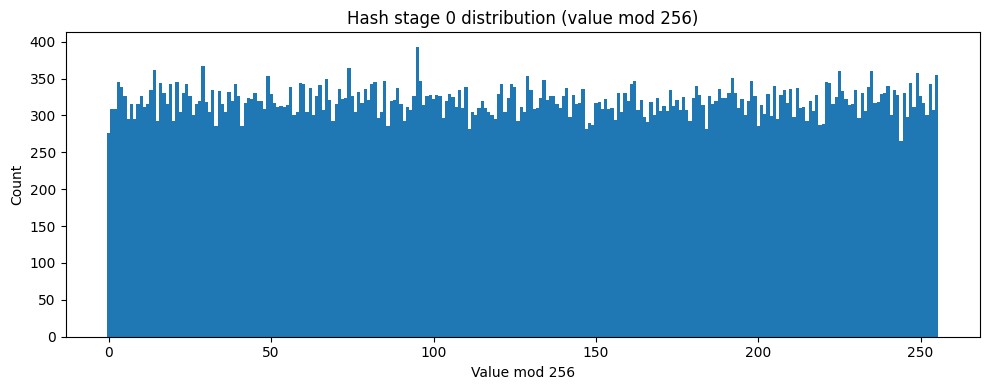

In [8]:
stage = 0
stage_buckets = hash_bucket_counts(stage_counts[stage], mod=256)
plt.figure(figsize=(10, 4))
plt.bar(range(256), stage_buckets, width=1.0)
plt.title(f"Hash stage {stage} distribution (value mod 256)")
plt.xlabel("Value mod 256")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
